**Imports**

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

device = 'cuda' if torch.cuda.is_available else 'cpu'
print(device)

cuda


In [2]:
train_df = pd.read_csv(r'V:\Sem_4_notes\Pytorch\Bean_leaf_lesions_classification\train.csv')
val_df = pd.read_csv(r'V:\Sem_4_notes\Pytorch\Bean_leaf_lesions_classification\val.csv')

print('Unique: ', train_df['category'].unique())
print(train_df['category'].value_counts()) #dataset is very less so we use here Transfer learning
train_df.head() 

Unique:  [0 1 2]
category
2    348
1    345
0    341
Name: count, dtype: int64


,image:FILE,category
0,train/healthy/healthy_train.98.jpg,0
1,train/healthy/healthy_train.148.jpg,0
2,train/healthy/healthy_train.306.jpg,0
3,train/healthy/healthy_train.305.jpg,0
4,train/healthy/healthy_train.40.jpg,0


In [3]:
transform = transforms.Compose([
  transforms.Resize((128,128)),
  transforms.ToTensor(),
  transforms.ConvertImageDtype(torch.float)
])

In [4]:
class CustomImageDastaset():
  def __init__(self, dataframe,base_dir,transform=None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(dataframe['category']).to(device)
    self.base_dir = base_dir

  def __len__(self):
    return self.dataframe.shape[0]
  
  def __getitem__(self, idx):
    image_path = os.path.join(self.base_dir,self.dataframe.iloc[idx, 0])
    label = self.labels[idx]

    image = Image.open(image_path)

    if self.transform:
      image = self.transform(image)/255.0

    return image, label
  

In [5]:
dir = r'V:\Sem_4_notes\Pytorch\Bean_leaf_lesions_classification'
train_dataset = CustomImageDastaset(dataframe = train_df,base_dir= dir,transform = transform)
val_dataset = CustomImageDastaset(dataframe = val_df,base_dir = dir ,transform = transform)

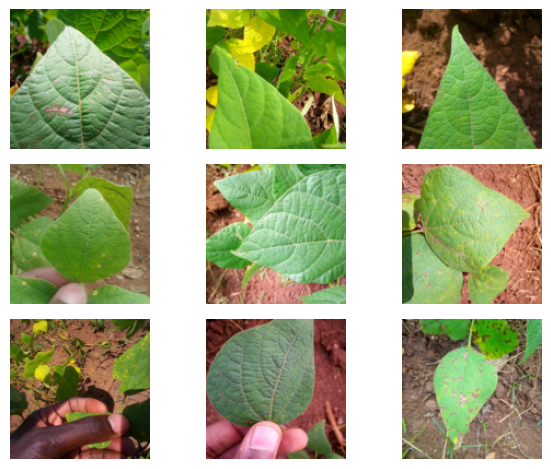

In [30]:
n_rows = 3
n_cols = 3

f, axarr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
  for col in range(n_cols):
    image = train_dataset[np.random.randint(0, len(train_dataset))][0].cpu()
    axarr[row, col].imshow((image*255.0).squeeze().permute(1,2,0))
    axarr[row, col].axis('off')

plt.tight_layout()
plt.show()

In [7]:
LR = 1e-2
BATCH_SIZE = 4
EPOCHS = 15

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle= True)
val_dataloader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle= True)

In [9]:
googlenet_model = models.googlenet(weights = 'DEFAULT')

In [10]:
for param in googlenet_model.parameters():
  param.requires_grad = True # parameters can be learned

In [54]:
googlenet_model.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [11]:
# we require 3 classe sin the output
# so we will change our model

num_classes = len(train_df['category'].unique())
googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model.fc

Linear(in_features=1024, out_features=3, bias=True)

In [12]:
print(device)

cuda


In [ ]:
# retraining the whole model again

googlenet_model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(googlenet_model.parameters(), lr= LR) 

total_loss_train_plot = []
total_acc_train_plot = []

for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0

  for inputs, labels in train_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()

    outputs = googlenet_model(inputs)

    train_loss = loss_fn(outputs, labels)
    total_loss_train += train_loss.item()

    train_loss.backward()

    train_acc = (torch.argmax(outputs,axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  total_loss_train_plot.append(round(total_loss_train/len(train_dataset), 4))
  total_acc_train_plot.append(round((total_acc_train/len(train_dataset))*100, 4))

  print(f'Epoch {epoch+1}/{EPOCHS} | train loss : {round(total_loss_train/len(train_dataset), 4)}, Train Accuracy : {round((total_acc_train/len(train_dataset))*100, 4)}')

# **Transfer learning**

In [13]:
googlenet_model = models.googlenet(weights = 'DEFAULT')

for param in googlenet_model.parameters():
  param.requires_grad = False

googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model.fc.requires_grad = True


In [15]:
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(googlenet_model.parameters(), lr = LR)

total_loss_train_plot = []
total_acc_train_plot = []

for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0

  for inputs, labels in train_dataloader:
    optimizer.zero_grad()

    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = googlenet_model(inputs)

    train_loss = loss_fn(outputs, labels)
    total_loss_train += train_loss

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()

    total_acc_train += train_acc
    train_loss.backward()
    
    optimizer.step()
  
  avg_train_loss = round(float(total_loss_train)/len(train_dataloader), 4)
  avg_train_acc = round((float(total_acc_train)/len(train_dataset))*100, 4)
  
  total_loss_train_plot.append(avg_train_loss)
  total_acc_train_plot.append(avg_train_acc)

  print(f"Epoch : {epoch+1}/{EPOCHS} | Train Loss : {avg_train_loss} | Train Accuracy : {avg_train_acc}%")

Epoch : 1/15 | Train Loss : 1.6187 | Train Accuracy : 47.3888%
Epoch : 2/15 | Train Loss : 1.7152 | Train Accuracy : 50.0%
Epoch : 3/15 | Train Loss : 1.7683 | Train Accuracy : 53.7718%
Epoch : 4/15 | Train Loss : 2.0305 | Train Accuracy : 53.8685%
Epoch : 5/15 | Train Loss : 1.7819 | Train Accuracy : 54.7389%
Epoch : 6/15 | Train Loss : 2.0347 | Train Accuracy : 54.6422%
Epoch : 7/15 | Train Loss : 1.9329 | Train Accuracy : 54.9323%
Epoch : 8/15 | Train Loss : 2.3342 | Train Accuracy : 54.5455%
Epoch : 9/15 | Train Loss : 2.0628 | Train Accuracy : 57.3501%
Epoch : 10/15 | Train Loss : 2.0455 | Train Accuracy : 54.5455%
Epoch : 11/15 | Train Loss : 2.0526 | Train Accuracy : 55.8994%
Epoch : 12/15 | Train Loss : 2.0241 | Train Accuracy : 54.6422%
Epoch : 13/15 | Train Loss : 2.0337 | Train Accuracy : 56.7698%
Epoch : 14/15 | Train Loss : 2.1036 | Train Accuracy : 54.6422%
Epoch : 15/15 | Train Loss : 1.711 | Train Accuracy : 60.735%


## **Target a Specific layer in Custom model**

### **Model**

In [23]:
import torch.nn as nn

class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.fc = nn.Linear(256*7*7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = nn.Flatten()(x)
        x = self.fc(x)
        return x
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model = MyCNN()

cuda


**Step 1: Freeze all layers**

In [28]:
for param in model.parameters():
  param.requires_grad = False

**Step 2: Unfreeze only `conv4`**

In [ ]:
for param in model.conv4.parameters():
  param.requires_grad = True


**Step 3: Create Optimizer for only trainable parameters**

In [ ]:
optimizer = torch.optim.Adam(
  filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4
)

**Target Multiple Specific Layers `conv4` & `conv3`**

In [29]:
for param in model.conv3.parameters():
  param.requires_grad = True

for param in model.conv4.parameters():
  param.requires_grad = True